# check for cross detection in SDSS of HPS objects

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd
import numpy as np
import os
import string as s

from astroquery.sdss import SDSS
from astropy import coordinates as coords
from astropy.io import fits
from astropy import wcs
from astropy import units as u
from astropy.table import Table
from astropy.nddata import Cutout2D

In [5]:
hps = pd.read_csv('/Users/Briana/Documents/Grad_School/HPS/HPS_dataframes/HPS_all_props.csv')
print hps.columns
obj = hps[hps['HPS_name']=='HPS100021+021351']
print obj.RA

Index([u'Unnamed: 0', u'Selection', u'HPS_name', u'Hb_absorption', u'ID',
       u'Source', u'[Ha]6562', u'[Ha]6562_e', u'[Hb]4861', u'[Hb]4861_e',
       u'[NII]6583', u'[NII]6583_e', u'[NeIII]3870', u'[NeIII]3870_e',
       u'[Ne]3870', u'[OIII]5007', u'[OIII]5007_e', u'[OIII]_HPS',
       u'[OIII]_e_HPS', u'[OII]3727', u'[OII]3727_e', u'E(B-V)', u'E(B-V)_err',
       u'OIII_int_err', u'OIII_intrinsic', u'met_err', u'metallicity', u'z',
       u'LogM', u'LogM_eu', u'LogM_el', u'LogM_e', u'met_eu', u'met_el',
       u'E(B-V)_eu', u'E(B-V)_el', u'OII_corr', u'OII_corr_eu', u'OII_corr_el',
       u'Lum_dist', u'SFR', u'SFR_met_corr', u'SFR_met_corr_eu',
       u'SFR_met_corr_el', u'SFR_eu', u'SFR_el', u'log_SFR_met_corr',
       u'log_SFR_met_corr_el', u'log_SFR_met_corr_eu', u'RA', u'DEC',
       u'OII_EW', u'OIII_EW'],
      dtype='object')
27    150.089542
Name: RA, dtype: float64


In [7]:
#**need to figure out which of the 4 fields are even in SDSS because others should not even be included**
for h in range(len(hps)):
    obj = hps.iloc[h]
    hps_name = obj['HPS_name']
    pos = coords.SkyCoord(obj.RA, obj.DEC, frame='icrs', unit='deg')
    xid = SDSS.query_region(pos, spectro=True)
    if xid != None:
        print xid.colnames
    print(hps_name, xid)

['ra', 'dec', 'objid', 'run', 'rerun', 'camcol', 'field', 'z', 'plate', 'mjd', 'fiberID', 'specobjid', 'run2d', 'instrument']
('HPS030638+000015', <Table length=1>
       ra                dec                 objid        ... run2d instrument
    float64            float64               int64        ... int64    str4   
---------------- -------------------- ------------------- ... ----- ----------
46.6618024456825 -0.00484478435337372 1237666300553986343 ...    26       SDSS)
('HPS022127-043019', None)
('HPS030649+000314', None)
('HPS030657+000139', None)
('HPS100018+021818', None)
('HPS100018+021426', None)
('HPS100032+021356', None)
('HPS100045+021823', None)
('HPS123636+621135', None)
('HPS123641+621131', None)
('HPS123648+621426', None)
('HPS123659+621404', None)
('HPS123702+621123', None)
('HPS030630+000128', None)
['ra', 'dec', 'objid', 'run', 'rerun', 'camcol', 'field', 'z', 'plate', 'mjd', 'fiberID', 'specobjid', 'run2d', 'instrument']
('HPS030638+000240', <Table length=1>
    

## Check if object in SDSS field 

In [11]:
class SDSS_match:
    def __init__(self, obj_name, RA, DEC, coord_units, search_rad=1):
        ''' Initialize variables '''
        self.obj_name = obj_name
        self.RA  = RA
        self.DEC = DEC
        self.coord_units = coord_units
        self.rad = search_rad
        
        self.pos = coords.SkyCoord(self.RA, self.DEC, unit=self.coord_units, frame='icrs')
        self.xid = SDSS.query_region(self.pos, radius=self.rad*u.arcsec, fields=['ra','dec','objid','run','rerun','camcol','field'])
        
        self.cut_size = (12.0,12.0)
        self.img   = np.zeros((30,30))
        self.wcs   = None

    def verbose_match(self, obj_z):
        if self.xid == None:
            print self.obj_name+' No match'+'\n'
        else:
            print self.obj_name+' Found '+str(len(self.xid))+' Objects'
            xid_spec = SDSS.query_region(self.pos, radius=self.rad*u.arcsec, spectro=True)
            if xid_spec != None:
                print '\t'+str(len(xid_spec))+' spectra: sdss_z='+str(xid_spec['z'].data[0])+' hps_z='+str(obj_z)
        
    def SDSS_get_image(self):
        if self.xid != None:
            xid1 = Table(np.array([np.array(self.xid[0])]), names=('ra','dec','run','rerun','camcol','field'))
            im_r = SDSS.get_images(matches=xid1, band='r') #6231 (red)

            im1 = im_r[0]
            dat = im1[0].data
            hdr = im1[0].header
            w = wcs.WCS(hdr)
            size = u.Quantity(self.cut_size, u.arcsec)
            cutout = Cutout2D(dat, self.pos, size, wcs=w, mode='partial', fill_value=0)
            
            self.img = cutout.data
            self.wcs = cutout.wcs
    
    def cutout_subplot(self, ax):
        self.SDSS_get_image()
        
        sha = np.shape(self.img)
        ra_coords  = np.ones(sha)
        dec_coords = np.ones(sha)

        if self.wcs != None:
            for i in range(sha[1]):
                for j in range(sha[0]):
                    (ra,dec), = self.wcs.wcs_pix2world([[i,j]], 0)
                    ra_coords[j,i]  = ra
                    dec_coords[j,i] = dec
                    
        ax.pcolor(ra_coords,dec_coords,self.img)
        ax.set_title(self.obj_name, size=12, weight='bold')
        

In [12]:
hps_targets = hps['HPS_name'].values
RA_lis = hps['RA'].values
DEC_lis = hps['DEC'].values
z_lis = hps['z'].values

for ax, name, ra, dec, z in zip(axes.flat, hps_targets, RA_lis, DEC_lis, z_lis):
    match = SDSS_match(name, ra, dec, 'deg', search_rad=3)
    match.verbose_match(z)

HPS030638+000015 Found 73 Objects
	1 spectra: sdss_z=0.1122338 hps_z=0.1121
HPS022127-043019 No match

HPS030649+000314 Found 33 Objects
HPS030657+000139 Found 35 Objects
HPS100018+021818 Found 2 Objects
HPS100018+021426 Found 1 Objects
HPS100032+021356 Found 2 Objects
HPS100045+021823 Found 3 Objects
HPS123636+621135 Found 4 Objects
HPS123641+621131 Found 4 Objects
HPS123648+621426 Found 3 Objects
HPS123659+621404 Found 3 Objects
HPS123702+621123 Found 6 Objects
HPS030630+000128 Found 30 Objects
HPS030638+000240 Found 34 Objects
	1 spectra: sdss_z=0.1125207 hps_z=0.1123
HPS030651-000234 Found 37 Objects
HPS030652+000123 Found 53 Objects
	3 spectra: sdss_z=0.1120346 hps_z=0.1121
HPS030655+000213 Found 28 Objects
HPS030655-000050 Found 67 Objects
	2 spectra: sdss_z=0.1121789 hps_z=0.1118
HPS100008+021542 Found 6 Objects
HPS100021+021223 No match

HPS100021+021237 No match

HPS100028+021858 Found 2 Objects
HPS100037+021254 Found 2 Objects
HPS100039+021246 Found 1 Objects
HPS123632+621037

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


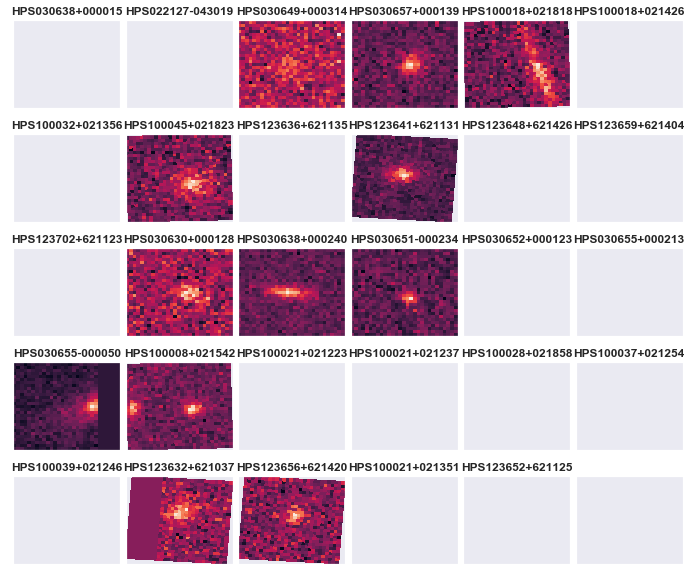

In [10]:
fig, axes = plt.subplots(5, 6, figsize=(12,10), subplot_kw={'xticks': [], 'yticks': []}) 
fig.subplots_adjust(hspace=0.3, wspace=0.05)

for ax, name, ra, dec in zip(axes.flat, hps_targets, RA_lis, DEC_lis):
    match = SDSS_match(name, ra, dec, 'deg')
    match.cutout_subplot(ax)
    
plt.show()